In [2]:
library(ggplot2)
library(dplyr)
library(ggdendro)
library(tidyverse)
library(gridExtra)
library(UpSetR)
library(RColorBrewer)

In [5]:
#Define dendrogram function genarating plot
dendro_data_k <- function(hc, k) {
  
  hcdata    <-  dendro_data(hc, type = "rectangle")
  seg       <-  hcdata$segments
  labclust  <-  cutree(hc, k)[hc$order]
  segclust  <-  rep(0L, nrow(seg))
  heights   <-  sort(hc$height, decreasing = TRUE)
  height    <-  mean(c(heights[k], heights[k - 1L]), na.rm = TRUE)
  
  for (i in 1:k) {
    xi      <-  hcdata$labels$x[labclust == i]
    idx1    <-  seg$x    >= min(xi) & seg$x    <= max(xi)
    idx2    <-  seg$xend >= min(xi) & seg$xend <= max(xi)
    idx3    <-  seg$yend < height
    idx     <-  idx1 & idx2 & idx3
    segclust[idx] <- i
  }
  
  idx                    <-  which(segclust == 0L)
  segclust[idx]          <-  segclust[idx + 1L]
  hcdata$segments$clust  <-  segclust
  hcdata$segments$line   <-  as.integer(segclust < 1L)
  hcdata$labels$clust    <-  labclust
  
  hcdata
}
#load file
tmp <- read.csv("raw_data/Lee_Belkhadir_exclude_contaminated_new_HM.csv")

names(tmp)[1] <- "ID"

#generate new dataframe
ipms <- dplyr::select(tmp,"Accession","Gene.Symbol",starts_with("log2Fold.change.Imputed"),starts_with("Adjusted.p.Value.imputed."))
head(ipms)

#Filter genes for heat map
ipms <- filter(ipms, Adjusted.p.Value.imputed.spl_FLS2_flg22..spl_FLS2_DMSO<0.1, abs(log2Fold.change.imputed.spl_FLS2_flg22..spl_FLS2_DMSO)>1)

#write ipms as a table

write.csv(ipms, 'raw_data/selected_p0.1_FC1.csv')


,Accession,Gene.Symbol,log2Fold.change.imputed.spl_FLS2_AgoC.spl_FLS2_DMSO,log2Fold.change.imputed.spl_FLS2_AgoD.spl_FLS2_DMSO,log2Fold.change.imputed.spl_FLS2_flg22..spl_FLS2_DMSO,Adjusted.p.Value.imputed.spl_FLS2_AgoC.spl_FLS2_DMSO,Adjusted.p.Value.imputed.spl_FLS2_AgoD.spl_FLS2_DMSO,Adjusted.p.Value.imputed.spl_FLS2_flg22..spl_FLS2_DMSO
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AT4G33430.2,BAK1,0.2108968,0.4422223,6.1526499,0.9998176,0.8868862,0.02735523
2,AT3G12390.1,AT3G12390,-0.7756827,-0.8383467,-4.7563309,0.9998176,0.8868862,0.02640714
3,AT5G60640.1,PDIL1-4,-0.3230818,-1.3645724,2.7039866,0.9998176,0.8868862,0.05545193
4,AT4G35060.1,AT4G35060; HIPP25,-1.1667154,-3.2648366,-0.7226103,0.9998176,0.8868862,0.94563782
5,AT3G15980.3;AT3G15980.2,AT3G15980,-0.1801479,-1.0468403,-3.0954196,0.9998176,0.8868862,0.02344807
6,AT1G72610.1,GER1,-2.8859648,-3.0624671,-0.2636116,0.9998176,0.8868862,0.97843872


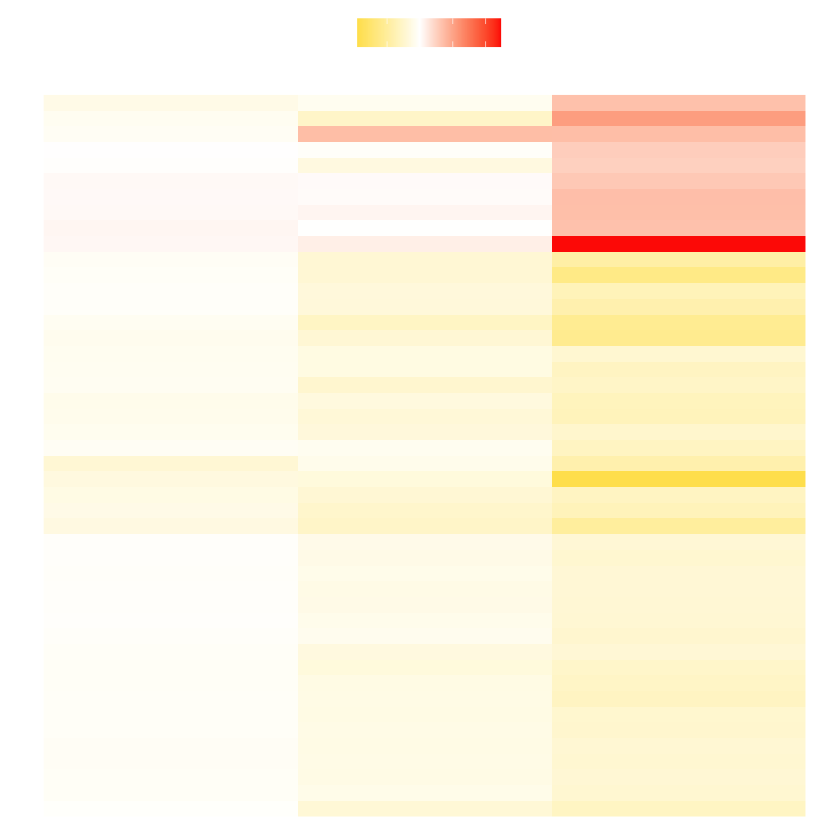

In [17]:
#Heatmap generation
#combine FC values for input of a heat map
HMinput <- dplyr::select(ipms,"Accession",starts_with("log2Fold.change.Imputed"))
colnames(HMinput)<-c('gene', 'Maya1', 'Maya2', 'flg22')
HMinput<-as.data.frame(HMinput)
rownames(HMinput)<-HMinput$gene
HMinput$gene<-NULL

#delete NA
HMinput <- filter(HMinput,!is.na(Maya1))
#Cluster genes using hclust()
distance<-dist(HMinput, method='canberra')
model<-hclust(distance, method='complete', members=NULL)

#Reorder HMinput by the clustering and organize into ggplot-optimized form
HMinput$gene<-rownames(HMinput)
HMinput$gene<-factor(HMinput$gene, levels=model$labels[model$order])
HMinput$gene<-NULL
HMinput2<-HMinput %>% rownames_to_column() %>% gather(colname, value, -rowname)
HMinput2$value<-as.numeric(HMinput2$value)
HMinput2$rowname<-factor(HMinput2$rowname, levels=model$labels[model$order])

#Generate dendrogram input based on clustering, colored branches
#The number designates number of clusters
ddata_2<-dendro_data_k(model, 3)

#Heatmap
heatmap<-ggplot(HMinput2, aes(x=colname, y=rowname, fill=value))+
  geom_raster()+ 
  #scale_fill_viridis(alpha = 1, begin = 0, end = 1, direction = 1, discrete = FALSE)+
  scale_fill_gradient2(low='#ffda00', mid='#ffffff', high='#ff2800', midpoint = 0 , na.value = NA)+
  scale_x_discrete(limits=c('Maya1', 'Maya2', 'flg22'))+
  theme(panel.background = element_blank(),
        axis.text.x=element_text(angle=0, hjust=0.5,vjust=1, size=0, color='black'),
        axis.text.y=element_blank(),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.title=element_text(size=0),
        legend.title = element_text(size=0),
        legend.text = element_text(size=0, margin=unit(c(0.2,0.2,0.2,0.2), "cm")),
        legend.spacing.y = unit(2,"cm"),
        legend.direction = ("horizontal"),
        legend.position = ("top")
        )
heatmap

In [19]:
# Set the file path and name for saving the heatmap
plot_final <- "Final/ig_3A_Heatmap_IP_MS.tif"

# Open the TIFF device with high resolution and DPI
tiff(plot_final, width = 4.6, height = 5.5, res = 600, units = "cm")
heatmap
dev.off()

pdf 
  2

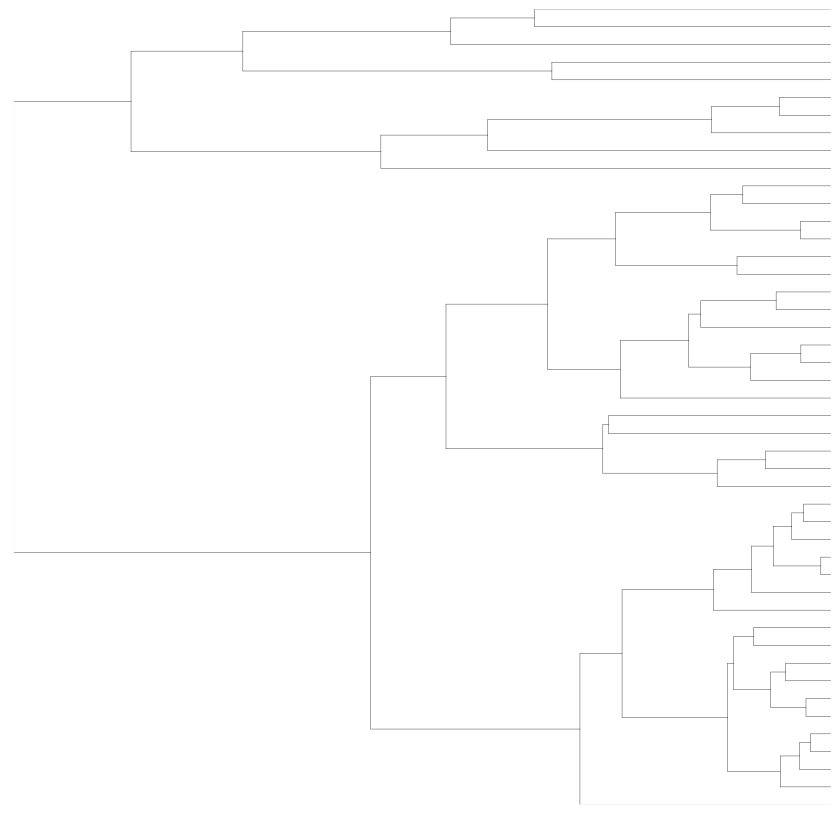

In [24]:
#Dendrogram
#cols <- c("#F4A7CC", "#D5008E", "#5AAC49")
Dendro<-ggplot()+geom_segment(data=segment(ddata_2), 
                              aes(x=x, y=y, xend=xend, yend=yend),
                              lineend="round", 
                              linewidth=0.1, 
                              show.legend=FALSE)+
  coord_flip()+
  scale_y_reverse(expand=c(0,0))+
  scale_x_continuous(expand=c(0,0))+
  theme_dendro()

Dendro


In [25]:
# Set the file path and name for saving the heatmap
plot_final <- "Final/ig_3A_Dendro_IP_MS.tif"

# Open the TIFF device with high resolution and DPI
tiff(plot_final, width = 1, height = 5.5, res = 600, units = "cm")
Dendro
dev.off()

pdf 
  2